In [1]:
import gym

In [108]:
import torch

In [2]:
import numpy as np

In [3]:
from matplotlib import pyplot as plt

In [20]:
env = gym.make('PongNoFrameskip-v4')
o = env.reset()

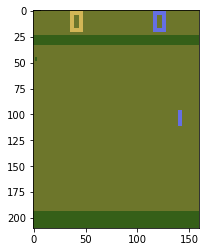

In [5]:
plt.imshow(o)

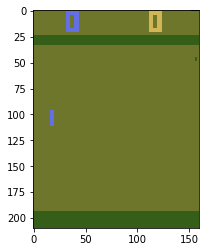

In [9]:
plt.imshow(np.fliplr(o))

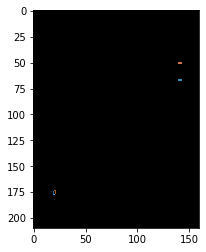

In [160]:
obs, reward, done, info = env.step(0)
obs2, reward, done, info = env.step(3)
plt.imshow(obs2-obs)

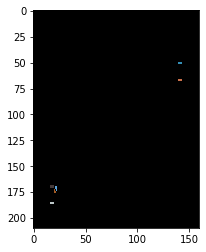

In [162]:
obs, reward, done, info = env.step(0)
obs2, reward, done, info = env.step(2)
plt.imshow(obs2-obs)

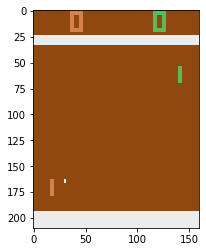

In [152]:
plt.imshow(obs)

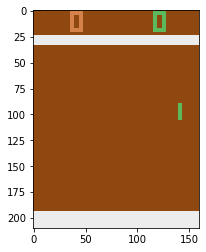

In [14]:
obs, reward, done, info = env.step(2)
plt.imshow(obs)

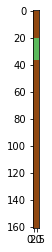

In [150]:
plt.imshow(obs2[33:194,140:144])

In [54]:
obs, reward, done, info = env.step(2)

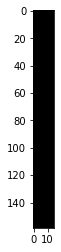

In [74]:
plt.imshow(np.fliplr(obs-obs2)[35:194,135:150])

In [78]:
temp = np.array(obs2[35:194,16:20])

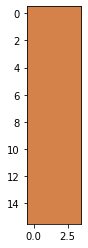

In [84]:
plt.imshow(temp[126:142])

In [85]:
op_pad = np.array(temp[126:142])

In [91]:
hold.shape

(185, 4, 3)

In [92]:
temp.shape

(159, 4, 3)

In [93]:
hold = list()
for i in range(159):
    hold.append(temp[0])
hold = np.array(hold)

In [97]:
hold[136:152] = op_pad

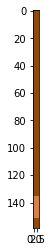

In [98]:
plt.imshow(hold)

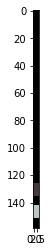

In [99]:
plt.imshow(temp-hold)

In [105]:
a = (temp-temp)[120:].flatten()

In [106]:
a[a!=0]

array([], dtype=uint8)

In [111]:
def state_to_tensor(I):
    """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
    if I is None:
        return torch.zeros(1, 6000)
    I = I[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    I = I[::2,::2,0] # downsample by factor of 2.
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
    return torch.from_numpy(I.astype(np.float32).ravel()).unsqueeze(0)

In [176]:
a = state_to_tensor(obs)

In [115]:
plt.figure()
plt.imshow(a.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')

RuntimeError: number of dims don't match in permute

<Figure size 432x288 with 0 Axes>

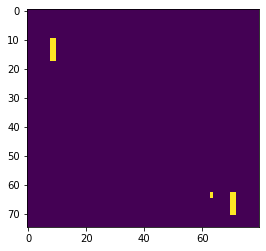

In [145]:
plt.imshow(np.fliplr(a.cpu().numpy().reshape(75,80)))

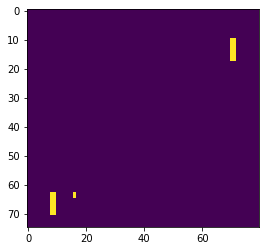

In [126]:
plt.imshow(a.cpu().numpy().reshape(75,80))

In [141]:
b = torch.from_numpy(I.astype(np.float32).ravel()).unsqueeze(0)

In [143]:
b

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [155]:
def get_action(x, prev_x):
    """Input: x, current screen; prev_x: previous screen
    Output: Returns opponent action. -1 for no action,0 for up, 1 for down"""
    if prev_x is None:
        prev_x = x
    movement = x - prev_x
    op_window = movement[33:194,140:144]
    #Remove 0s and see the action
    op_window = op_window[op_window != 0]
    if len(op_window) == 0:
        return -1
    if op_window[0] < 100:
        return 0
    else:
        return 1

In [210]:
np.sum(torch.load("params.ckpt")['layers.0.weight'].cpu().numpy() - torch.load("BCloneparams.ckpt")['layers.0.weight'].cpu().numpy())

26.385748

In [178]:
import gym
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
#from model import Policy
import time


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(6000*2, 512), nn.ReLU(),
            nn.Linear(512, 2),
        )

    def state_to_tensor(self, I, opponent=False):
        """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
        if I is None:
            return torch.zeros(1, 6000)
        if opponent:
            I = np.fliplr(I)
        I = I[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
        I = I[::2,::2,0] # downsample by factor of 2.
        I[I == 144] = 0 # erase background (background type 1)
        I[I == 109] = 0 # erase background (background type 2)
        I[I != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
        return torch.from_numpy(I.astype(np.float32).ravel()).unsqueeze(0).to('cuda')

    def pre_process(self, x, prev_x, opponent=False):
        #return self.state_to_tensor(x) - self.state_to_tensor(prev_x)
        return torch.cat([self.state_to_tensor(x, opponent), self.state_to_tensor(prev_x, opponent)], dim=1)

    def convert_action(self, action):
        return action + 2

    def forward(self, d_obs, deterministic=False):
        logits = self.layers(d_obs)
        if deterministic:
            action = int(torch.argmax(logits[0]).detach().cpu().numpy())
            action_prob = 1.0
        else:
            c = torch.distributions.Categorical(logits=logits)
            action = int(c.sample().cpu().numpy()[0])
            action_prob = float(c.probs[0, action].detach().cpu().numpy())
        return action, action_prob, logits


In [179]:
policy = Policy().to('cuda')
policy.load_state_dict(torch.load("params.ckpt"))

<All keys matched successfully>

In [182]:
d_obs = policy.pre_process(obs2, obs)

In [183]:
d_obs

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [184]:
policy(d_obs)

(0,
 0.8192578554153442,
 tensor([[ 0.6872, -0.8241]], device='cuda:0', grad_fn=<AddmmBackward>))

In [206]:
import gym
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
#from model import Policy
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes)
    return y[labels]

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(6000*2, 512), nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, d_obs, deterministic=False):
        logits = self.layers(d_obs)
        if deterministic:
            action = int(torch.argmax(logits[0]))
            action_prob = 1.0
        else:
            c = torch.distributions.Categorical(logits=logits)
            action = c.sample()
            action_prob = c.probs[0, action]
        return action, action_prob, logits

    def state_to_tensor(self, I, opponent=False):
        """ prepro 210x160x3 uint8 frame into 6000 (75x80) 1D float vector """
        if I is None:
            return torch.zeros(1, 6000)
        if opponent:
            I = np.fliplr(I)
        I = I[35:185] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
        I = I[::2,::2,0] # downsample by factor of 2.
        I[I == 144] = 0 # erase background (background type 1)
        I[I == 109] = 0 # erase background (background type 2)
        I[I != 0] = 1 # everything else (paddles, ball) just set to 1. this makes the image grayscale effectively
        return torch.from_numpy(I.astype(np.float32).ravel()).unsqueeze(0)

    def pre_process(self, x, prev_x, opponent=False):
        #return self.state_to_tensor(x) - self.state_to_tensor(prev_x)
        return torch.cat([self.state_to_tensor(x, opponent), self.state_to_tensor(prev_x, opponent)], dim=1)

    def convert_action(self, action):
        return action + 2



policy = Policy()
policy.load_state_dict(torch.load("params.ckpt"))

#Define loss criterion
criterion = nn.BCEWithLogitsLoss()
#Define the optimizer
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)

def get_opponent_screen(obs):
    numpy_obs = np.fliplr(obs.cpu().numpy().reshape(75, 80))
    return torch.from_numpy(numpy_obs.astype(np.float32).ravel()).unsqueeze(0)

def get_opponent_action(x, prev_x):
    """Input: x, current screen; prev_x: previous screen
    Output: Returns opponent action. -1 for no action, 0 for up, 1 for down"""
    if prev_x is None:
        prev_x = x
    movement = x - prev_x
    op_window = movement[35:194, 16:20]
    #Remove 0s and see the action
    op_window = op_window[op_window != 0]
    if len(op_window) == 0:
        return -1
    if op_window[0] < 100:
        return 0
    else:
        return 1


env = gym.make('PongNoFrameskip-v4')
# env = gym.wrappers.Monitor(env, './tmp', video_callable=lambda ep_id: True, force=True)
env.reset()

policy = Policy()
policy.load_state_dict(torch.load('params.ckpt'))
policy.train()



for episode in range(2):
    prev_obs = None
    op_action_pred = -1
    op_action_prob = 0
    op_action_logit = 0

    correct_hold = []
    op_action_hold = []
    op_action_prob_hold = []
    op_action_logit_hold = torch.Tensor()
    obs = env.reset()
    
    
    for t in range(200):
        d_obs = policy.pre_process(obs, prev_obs)
        op_obs = policy.pre_process(obs, prev_obs, opponent=True)
        op_action_real = get_opponent_action(obs, prev_obs)
        if op_action_real != -1:
            op_action_hold.append(torch.tensor(op_action_real))
            op_action_prob_hold.append(op_action_prob)
            op_action_logit_hold = torch.cat((op_action_logit_hold,op_action_logit))
            correct_hold.append(op_action_real == op_action_pred)


        action, action_prob, _ = policy(d_obs)
        op_action_pred, op_action_prob, op_action_logit = policy(op_obs)

        prev_obs = obs
        obs, reward, done, info = env.step(policy.convert_action(action))

        if done:
            print('Episode %d (%d timesteps) - Reward: %.2f' % (episode, t, reward))
            break
    actions_stack = torch.stack(op_action_hold)
    actions_stack = one_hot_embedding(actions_stack, 2)
    #print(op_action_logit_hold.shape)
    #print(actions_stack.shape)

    op_action_logit_hold, actions_stack = op_action_logit_hold, actions_stack
    # Clear the previous gradients
    optimizer.zero_grad()

    loss = criterion(op_action_logit_hold, actions_stack)
    # Compute gradients
    loss.backward()
    # Adjust weights
    optimizer.step()

        # time.sleep(0.033)
    print("{}% correct guesses".format(np.mean(correct_hold)))
    print("{} Cross Entropy Loss".format(loss.item()))
env.close()
#torch.save(policy.state_dict(), 'BCloneparams.ckpt')


0.4563106796116505% correct guesses
1.1280885934829712 Cross Entropy Loss
0.4174757281553398% correct guesses
1.1043877601623535 Cross Entropy Loss


In [207]:
for params in policy.parameters():
    print(params)

Parameter containing:
tensor([[ 2.7282e-03, -6.3551e-03,  8.5427e-03,  ..., -8.2178e-04,
         -8.6679e-03,  8.8686e-03],
        [-2.7220e-03,  7.3837e-03, -3.2218e-02,  ...,  1.5766e-02,
          2.4773e-02,  9.0578e-03],
        [ 3.2827e-03, -7.2522e-03,  1.0313e-03,  ..., -8.3026e-02,
         -2.8450e-02, -8.9360e-03],
        ...,
        [ 2.8302e-03, -2.9590e-03, -4.5707e-04,  ...,  4.1055e-02,
          5.2447e-03,  8.9091e-03],
        [ 4.3164e-03, -7.9251e-04,  8.3127e-03,  ...,  3.3355e-02,
         -1.4933e-03, -1.4245e-03],
        [ 6.6437e-04, -1.9066e-03,  4.7092e-02,  ..., -3.3145e-02,
         -4.6257e-02,  6.7445e-05]], requires_grad=True)
Parameter containing:
tensor([-1.1197e-03,  1.0470e-03, -1.1648e-02, -4.9447e-03, -4.2165e-03,
         2.6186e-03, -8.4325e-03, -3.6583e-04, -6.9580e-03,  9.9776e-04,
        -2.8419e-02, -5.1009e-03, -1.4483e-02, -7.2500e-03,  2.2474e-03,
        -1.2910e-02,  2.7167e-03, -1.4679e-02, -3.3769e-03, -7.9711e-03,
        -1.4

In [199]:
torch.load("params.ckpt")

OrderedDict([('layers.0.weight',
              tensor([[ 2.7282e-03, -6.3551e-03,  8.5427e-03,  ..., -8.2178e-04,
                       -8.6679e-03,  8.8686e-03],
                      [-2.7220e-03,  7.3837e-03, -3.2218e-02,  ...,  1.5766e-02,
                        2.4773e-02,  9.0578e-03],
                      [ 3.2827e-03, -7.2522e-03,  1.0313e-03,  ..., -8.3026e-02,
                       -2.8450e-02, -8.9360e-03],
                      ...,
                      [ 2.8302e-03, -2.9590e-03, -4.5707e-04,  ...,  4.1055e-02,
                        5.2447e-03,  8.9091e-03],
                      [ 4.3164e-03, -7.9251e-04,  8.3127e-03,  ...,  3.3355e-02,
                       -1.4933e-03, -1.4245e-03],
                      [ 6.6437e-04, -1.9066e-03,  4.7092e-02,  ..., -3.3145e-02,
                       -4.6257e-02,  6.7445e-05]])),
             ('layers.0.bias',
              tensor([-1.1197e-03,  1.0470e-03, -1.1648e-02, -4.9447e-03, -4.2165e-03,
                       2.6186e-03